# Download data

In [10]:
# Fruits-360 dataset をダウンロードし、解凍する

!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rp73yg93n8-1.zip -nc -P ./data/
!unzip -n ./data/rp73yg93n8-1.zip -d ./data/
!unzip -n -q ./data/fruits-360_dataset.zip -d ./data/ 

ファイル `./data/rp73yg93n8-1.zip' はすでに存在するので、取得しません。

Archive:  ./data/rp73yg93n8-1.zip


# Import

In [11]:
import os
import random
from glob import glob
from warnings import filterwarnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.init as init
from natsort import natsorted
from PIL import Image
from skimage import io, transform
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset
# from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

from torchsummary import summary

filterwarnings("ignore")  # warningをオフにする

# Config

In [12]:
IMAGE_SIZE = 96  # 画像の読み込みサイズ
EMBED_SIZE = 128  # 潜在変数zの次元数
BATCH_SIZE = 16  # バッチサイズ
EPOCHS = 1000  # エポック数
LR = 0.0004  # 学習率

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # GPUが使えるならGPUで、そうでないならCPUで計算する
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}  

In [28]:
COLAB_FLG = False

if COLAB_FLG:
    from google.colab import drive
    drive.mount('/content/gdrive') # マウント先
    ATTACH_PATH = "/content/gdrive/MyDrive/Colab Notebooks/gan_sample/chapter8"  # 保存先のベースディレクトリ
else:
    ATTACH_PATH = "."  # ローカルならカレントディレクトリ
    

SAVE_MODEL_PATH = f"{ATTACH_PATH}/results/EfficientGAN_L1_gray/model/"  # モデルの保存先
SAVE_IMAGE_FROM_Z_PATH = f"{ATTACH_PATH}/results/EfficientGAN_L1_gray/image/image_from_z/"  # 乱数から生成した画像の保存先
SAVE_IMAGE_RECONSTRUCT = f"{ATTACH_PATH}/results/EfficientGAN_L1_gray/image/RECONSTRUCT/"  # 再構成した画像の保存先

# 保存先のディレクトリを作成する
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)
os.makedirs(SAVE_IMAGE_FROM_Z_PATH, exist_ok=True)
os.makedirs(SAVE_IMAGE_RECONSTRUCT, exist_ok=True)

# Data Loader

In [29]:
train_root = './data/fruits-360/Training/Physalis/'  # train dataの保存してあるディレクトリ
val_root = './data/fruits-360/Test/Physalis/'  # val dataの保存してあるディレクトリ

In [30]:
# ディレクトリから画像を読み込んでDataLoaderに渡す用のクラス

class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = natsorted(os.listdir(main_dir))
        self.all_imgs_name = natsorted(all_imgs)
        self.imgs_loc = [os.path.join(self.main_dir, i) for i in self.all_imgs_name]

    def __len__(self):
        return len(self.all_imgs_name)
    
    def load_image(self, path):
        image = Image.open(path).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image
    
    def __getitem__(self, idx):
        
        # 後ほどsliceで画像を複数枚取得したいのでsliceでも取れるようにする
        if type(idx) == slice:
            paths = self.imgs_loc[idx]
            tensor_image = [self.load_image(path) for path in paths]
            tensor_image = torch.cat(tensor_image).reshape(len(tensor_image), *tensor_image[0].shape)
        elif type(idx) == int:
            path = self.imgs_loc[idx]
            tensor_image = self.load_image(path)
        return tensor_image

In [31]:
# 画像を読み込む際の前処理

transform_dict = {
    "train": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # IMAGE_SIZEにreshape
            transforms.RandomHorizontalFlip(), # ランダムに左右反転を行う
            transforms.ToTensor(),
            transforms.Grayscale(num_output_channels=1), # RGB to grayscale
            transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # grayscalt to 3channels
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # IMAGE_SIZEにreshape
            transforms.ToTensor(),
            transforms.Grayscale(num_output_channels=1), # RGB to grayscale
            transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # grayscalt to 3channels
        ]
    ),
}

In [32]:
# 読み込む

train_dataset = LoadFromFolder(train_root, transform=transform_dict["train"])

val_dataset = LoadFromFolder(val_root, transform=transform_dict["test"])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

# Model

In [33]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2), #48x48
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2), #24x24

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2), #12x12
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2), #6x6

        
            nn.Conv2d(256, 512, kernel_size=6, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2), #1x1

            nn.Conv2d(512, 512, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2), #1x1
        )
        
        self.last = nn.Sequential(
            nn.Conv2d(512, EMBED_SIZE, kernel_size=1, stride=1, bias=False)
        )


    def forward(self, x):
        
        out = self.main(x)

        out = self.last(out)
        out = out.view(out.size()[0], -1, 1, 1)
        return out

In [34]:
# ネットワークを可視化する

summary(Encoder().to(device), (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]           1,536
       BatchNorm2d-2           [-1, 32, 48, 48]              64
         LeakyReLU-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 24, 24]          32,768
       BatchNorm2d-5           [-1, 64, 24, 24]             128
         LeakyReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 12, 12]         131,072
       BatchNorm2d-8          [-1, 128, 12, 12]             256
         LeakyReLU-9          [-1, 128, 12, 12]               0
           Conv2d-10            [-1, 256, 6, 6]         524,288
      BatchNorm2d-11            [-1, 256, 6, 6]             512
        LeakyReLU-12            [-1, 256, 6, 6]               0
           Conv2d-13            [-1, 512, 1, 1]       4,718,592
      BatchNorm2d-14            [-1, 51

In [35]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(EMBED_SIZE, 256, kernel_size=6, stride=1, padding=0, bias=False), # 6x6
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), # 12x12
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False), # 24x24
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False), # 48x48
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False), #96x96
            nn.Tanh()
        )

    def forward(self, z):
        out = self.main(z)
        return out

In [36]:
# ネットワークを可視化する

summary(Generator().to(device), tuple([EMBED_SIZE, 1, 1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 6, 6]       1,179,648
       BatchNorm2d-2            [-1, 256, 6, 6]             512
         LeakyReLU-3            [-1, 256, 6, 6]               0
   ConvTranspose2d-4          [-1, 128, 12, 12]         524,288
       BatchNorm2d-5          [-1, 128, 12, 12]             256
         LeakyReLU-6          [-1, 128, 12, 12]               0
   ConvTranspose2d-7           [-1, 64, 24, 24]         131,072
       BatchNorm2d-8           [-1, 64, 24, 24]             128
         LeakyReLU-9           [-1, 64, 24, 24]               0
  ConvTranspose2d-10           [-1, 32, 48, 48]          32,768
      BatchNorm2d-11           [-1, 32, 48, 48]              64
        LeakyReLU-12           [-1, 32, 48, 48]               0
  ConvTranspose2d-13            [-1, 3, 96, 96]           1,536
             Tanh-14            [-1, 3,

In [37]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
            
        self.x_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True), #48x48
            nn.Dropout2d(p=0.3),
            
            nn.AvgPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True), #24x24
            nn.Dropout2d(p=0.3),

            nn.AvgPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True), #12x12
            nn.Dropout2d(p=0.3),
            
            nn.AvgPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True), #6x6
            nn.Dropout2d(p=0.3),
            
            nn.AvgPool2d(2),
            nn.Conv2d(256, 256, kernel_size=6, stride=1) #1x1

        )
        self.z_layer = nn.Sequential(
            nn.Conv2d(EMBED_SIZE, 256, kernel_size=1, stride=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(p=0.2),
            

            
        )
        
        self.last1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1, stride=1),
            nn.LeakyReLU(0.1, inplace=False),
            nn.Dropout2d(p=0.2),
            
            
 
        )
        self.last2 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1, stride=1),
        )

    def forward(self, x, z):
        
        output_x = self.x_layer(x)
        output_z = self.z_layer(z)
        
        concat_x_z = torch.cat((output_x, output_z), 1)
        output = self.last1(concat_x_z)

        feature = output.view(output.size()[0], -1)
        
        output = self.last2(output)
        output = F.sigmoid(output)
        return output.squeeze(), feature

In [38]:
# ネットワークを可視化する

summary(Discriminator().to(device), [(3, IMAGE_SIZE, IMAGE_SIZE), (EMBED_SIZE, 1, 1)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
         LeakyReLU-2           [-1, 32, 96, 96]               0
         Dropout2d-3           [-1, 32, 96, 96]               0
         AvgPool2d-4           [-1, 32, 48, 48]               0
            Conv2d-5           [-1, 64, 48, 48]          18,496
       BatchNorm2d-6           [-1, 64, 48, 48]             128
         LeakyReLU-7           [-1, 64, 48, 48]               0
         Dropout2d-8           [-1, 64, 48, 48]               0
         AvgPool2d-9           [-1, 64, 24, 24]               0
           Conv2d-10          [-1, 128, 24, 24]          73,856
      BatchNorm2d-11          [-1, 128, 24, 24]             256
        LeakyReLU-12          [-1, 128, 24, 24]               0
        Dropout2d-13          [-1, 128, 24, 24]               0
        AvgPool2d-14          [-1, 128,

In [39]:
# 重みの初期化を行う関数


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find("Linear") != -1:
        m.bias.data.fill_(0)

In [40]:
model_E = Encoder().to(device)
model_E.apply(weights_init)

model_G = Generator().to(device)
model_G.apply(weights_init)

model_D = Discriminator().to(device)
model_D.apply(weights_init)

criterion = nn.BCELoss()
criterion_L1 = nn.L1Loss(reduction="sum")  # L1 lossも学習時に用いる

optimizer_ge = torch.optim.Adam(list(model_G.parameters()) + list(model_E.parameters()), lr= LR, betas=(0.5,0.999))
optimizer_d = torch.optim.Adam(model_D.parameters(), lr= LR,betas=(0.5,0.999))
scheduler_ge = torch.optim.lr_scheduler.StepLR(optimizer_ge, step_size=50, gamma=0.9)
scheduler_d = torch.optim.lr_scheduler.StepLR(optimizer_d, step_size=50, gamma=0.9)

# Train

In [41]:
def Anomaly_score(x, E_x, G_E_x, Lambda=0.1):
    
    _,x_feature = model_D(x, E_x)
    _,G_E_x_feature = model_D(G_E_x, E_x)
    
    residual_loss = criterion_L1(x, G_E_x)
    discrimination_loss = criterion_L1(x_feature, G_E_x_feature)
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    total_loss = total_loss.item()

    return total_loss


In [42]:
loss_d_list, loss_ge_list, anomaly_score_list = [], [], []


for epoch in range(EPOCHS):
    loss_d_sum = 0
    loss_ge_sum = 0
    anomaly_score_sum = 0
    
    for i,(x, x_val) in enumerate(zip(train_loader, val_loader)):
        
        model_G.train()
        model_D.train()
        model_E.train()
        # set values
        y_true = Variable(torch.ones(x.size()[0])).to(device)
        y_fake = Variable(torch.zeros(x.size()[0])).to(device)
        
        x = Variable(x).to(device)
        z = Variable(init.normal(torch.Tensor(x.size()[0],EMBED_SIZE, 1, 1),mean=0,std=0.1)).to(device)
        
        # noise for discriminator
        noise1 = Variable(torch.Tensor(x.size()).normal_(0, 0.1 * (EPOCHS - epoch) / EPOCHS),
                          requires_grad=False).to(device)
        noise2 = Variable(torch.Tensor(x.size()).normal_(0, 0.1 * (EPOCHS - epoch) / EPOCHS),
                          requires_grad=False).to(device)

        # discriminator
        optimizer_d.zero_grad()
        
        E_x = model_E(x) 
        p_true, _ = model_D(x + noise1, E_x)
        
        G_z = model_G(z)
        p_fake, _ = model_D(G_z + noise2, z)
        
        loss_d = criterion(p_true, y_true) + criterion(p_fake, y_fake)
        loss_d.backward(retain_graph=True)
        optimizer_d.step()
        
        # generator and encoder
        optimizer_ge.zero_grad()
        
        G_E_x = model_G(E_x)
        E_G_z = model_E(G_z)
    
        p_true, _ = model_D(x + noise1, E_x)
        
        # G_z = model_G(z)
        p_fake, _ = model_D(G_z + noise2, z)
        
        
        loss_ge_1 = criterion(p_fake, y_true) + criterion(p_true, y_fake)
        loss_ge_2 = criterion_L1(x, G_E_x) +  criterion_L1(z, E_G_z)
        
        alpha = 0.01
        
        loss_ge = (1 - alpha)*loss_ge_1 + alpha*loss_ge_2
        loss_ge.backward(retain_graph=True)
        optimizer_ge.step()
        
        
        loss_d_sum += loss_d.item()
        loss_ge_sum += loss_ge.item()
        
        # record anomaly score
        
        model_G.eval()
        model_D.eval()
        model_E.eval()
        x_val = Variable(x_val).to(device)
        E_x_val = model_E(x_val)
        G_E_x_val = model_G(E_x_val)
        anomaly_score_sum += Anomaly_score(x_val, E_x_val, G_E_x_val)

            
        # save images
        if i == 0:
            
            model_G.eval()
            model_D.eval()
            model_E.eval()
        
            save_image_size_for_z = min(BATCH_SIZE, 8)
            save_images = model_G(z)
            save_image(save_images[:save_image_size_for_z], f"{SAVE_IMAGE_FROM_Z_PATH}/epoch_{epoch}.png", nrow=4)

            save_image_size_for_recon = min(BATCH_SIZE, 8)
            images = x[:save_image_size_for_recon]
            G_E_x = model_G(model_E(images))
            diff_images = torch.abs(images - G_E_x)
            comparison = torch.cat([images , G_E_x, diff_images]).to("cpu")
            save_image(comparison, f"{SAVE_IMAGE_RECONSTRUCT}/epoch_{epoch}.png", nrow=save_image_size_for_recon)
            
    scheduler_ge.step()
    scheduler_d.step()
        
    # record loss
    loss_d_mean = loss_d_sum / len(train_loader)
    loss_ge_mean = loss_ge_sum / len(train_loader)
    anomaly_score_mean = anomaly_score_sum / len(train_loader)
    
    print(f"{epoch}/{EPOCHS} epoch ge_loss: {loss_ge_mean:.3f} d_loss: {loss_d_mean:.3f} anomaly_score: {anomaly_score_mean:.3f}")
    
    loss_d_list.append(loss_d_mean)
    loss_ge_list.append(loss_ge_mean)
    anomaly_score_list.append(anomaly_score_mean)
    
    # save model
    if (epoch + 1) % 10 == 0:
        torch.save(model_G.state_dict(),f'{SAVE_MODEL_PATH}/Generator_{epoch + 1}.pkl')
        torch.save(model_E.state_dict(),f'{SAVE_MODEL_PATH}/Encoder_{epoch + 1}.pkl')
        torch.save(model_D.state_dict(),f'{SAVE_MODEL_PATH}/Discriminator_{epoch + 1}.pkl')


0/1000 epoch ge_loss: 962.594 d_loss: 0.281 anomaly_score: 89055.376
1/1000 epoch ge_loss: 640.259 d_loss: 0.016 anomaly_score: 58103.834
2/1000 epoch ge_loss: 361.751 d_loss: 0.054 anomaly_score: 29971.036
3/1000 epoch ge_loss: 220.952 d_loss: 0.104 anomaly_score: 17235.983
4/1000 epoch ge_loss: 152.767 d_loss: 0.092 anomaly_score: 12966.875
5/1000 epoch ge_loss: 122.033 d_loss: 0.032 anomaly_score: 13146.797
6/1000 epoch ge_loss: 104.293 d_loss: 0.074 anomaly_score: 9564.276
7/1000 epoch ge_loss: 90.705 d_loss: 0.011 anomaly_score: 9456.654
8/1000 epoch ge_loss: 84.181 d_loss: 0.010 anomaly_score: 8198.607
9/1000 epoch ge_loss: 77.197 d_loss: 0.010 anomaly_score: 7723.724
10/1000 epoch ge_loss: 72.438 d_loss: 0.010 anomaly_score: 6703.950
11/1000 epoch ge_loss: 66.432 d_loss: 0.008 anomaly_score: 6792.550
12/1000 epoch ge_loss: 64.965 d_loss: 0.020 anomaly_score: 6164.619
13/1000 epoch ge_loss: 69.910 d_loss: 0.015 anomaly_score: 7712.996
14/1000 epoch ge_loss: 64.048 d_loss: 0.003 a

121/1000 epoch ge_loss: 29.143 d_loss: 0.039 anomaly_score: 2518.642
122/1000 epoch ge_loss: 34.992 d_loss: 0.035 anomaly_score: 2923.271
123/1000 epoch ge_loss: 31.455 d_loss: 0.091 anomaly_score: 2818.477
124/1000 epoch ge_loss: 28.547 d_loss: 0.015 anomaly_score: 2961.735
125/1000 epoch ge_loss: 34.880 d_loss: 0.022 anomaly_score: 3234.592
126/1000 epoch ge_loss: 31.057 d_loss: 0.019 anomaly_score: 2626.368
127/1000 epoch ge_loss: 30.620 d_loss: 0.028 anomaly_score: 2855.204
128/1000 epoch ge_loss: 30.624 d_loss: 0.046 anomaly_score: 3073.833
129/1000 epoch ge_loss: 55.464 d_loss: 0.015 anomaly_score: 3463.346
130/1000 epoch ge_loss: 43.072 d_loss: 0.003 anomaly_score: 3170.074
131/1000 epoch ge_loss: 36.368 d_loss: 0.013 anomaly_score: 2957.157
132/1000 epoch ge_loss: 31.850 d_loss: 0.035 anomaly_score: 2831.842
133/1000 epoch ge_loss: 32.281 d_loss: 0.052 anomaly_score: 2921.229
134/1000 epoch ge_loss: 29.483 d_loss: 0.035 anomaly_score: 2555.611
135/1000 epoch ge_loss: 31.257 d_l

240/1000 epoch ge_loss: 22.847 d_loss: 0.155 anomaly_score: 2172.318
241/1000 epoch ge_loss: 22.459 d_loss: 0.149 anomaly_score: 2462.164
242/1000 epoch ge_loss: 22.149 d_loss: 0.190 anomaly_score: 2275.865
243/1000 epoch ge_loss: 23.186 d_loss: 0.137 anomaly_score: 2461.936
244/1000 epoch ge_loss: 22.338 d_loss: 0.145 anomaly_score: 2267.367
245/1000 epoch ge_loss: 23.370 d_loss: 0.116 anomaly_score: 2352.549
246/1000 epoch ge_loss: 22.312 d_loss: 0.151 anomaly_score: 2246.598
247/1000 epoch ge_loss: 26.094 d_loss: 0.146 anomaly_score: 2644.379
248/1000 epoch ge_loss: 22.159 d_loss: 0.119 anomaly_score: 2461.551
249/1000 epoch ge_loss: 22.031 d_loss: 0.168 anomaly_score: 2313.298
250/1000 epoch ge_loss: 20.990 d_loss: 0.143 anomaly_score: 2261.382
251/1000 epoch ge_loss: 21.686 d_loss: 0.151 anomaly_score: 2262.164
252/1000 epoch ge_loss: 21.662 d_loss: 0.105 anomaly_score: 2176.186
253/1000 epoch ge_loss: 21.286 d_loss: 0.165 anomaly_score: 2194.787
254/1000 epoch ge_loss: 20.536 d_l

359/1000 epoch ge_loss: 18.777 d_loss: 0.119 anomaly_score: 2163.449
360/1000 epoch ge_loss: 19.783 d_loss: 0.142 anomaly_score: 2159.575
361/1000 epoch ge_loss: 18.953 d_loss: 0.119 anomaly_score: 2160.385
362/1000 epoch ge_loss: 18.962 d_loss: 0.163 anomaly_score: 2105.763
363/1000 epoch ge_loss: 19.241 d_loss: 0.155 anomaly_score: 2071.373
364/1000 epoch ge_loss: 19.038 d_loss: 0.195 anomaly_score: 2034.295
365/1000 epoch ge_loss: 18.494 d_loss: 0.199 anomaly_score: 1995.045
366/1000 epoch ge_loss: 19.089 d_loss: 0.157 anomaly_score: 1997.437
367/1000 epoch ge_loss: 19.665 d_loss: 0.166 anomaly_score: 2014.811
368/1000 epoch ge_loss: 18.493 d_loss: 0.166 anomaly_score: 1980.436
369/1000 epoch ge_loss: 19.467 d_loss: 0.123 anomaly_score: 2024.246
370/1000 epoch ge_loss: 19.180 d_loss: 0.106 anomaly_score: 2057.448
371/1000 epoch ge_loss: 20.358 d_loss: 0.162 anomaly_score: 2101.348
372/1000 epoch ge_loss: 19.013 d_loss: 0.121 anomaly_score: 1954.431
373/1000 epoch ge_loss: 21.038 d_l

478/1000 epoch ge_loss: 17.323 d_loss: 0.179 anomaly_score: 1880.680
479/1000 epoch ge_loss: 16.869 d_loss: 0.183 anomaly_score: 1775.115
480/1000 epoch ge_loss: 16.872 d_loss: 0.217 anomaly_score: 1835.051
481/1000 epoch ge_loss: 17.982 d_loss: 0.160 anomaly_score: 1929.730
482/1000 epoch ge_loss: 17.606 d_loss: 0.139 anomaly_score: 1955.432
483/1000 epoch ge_loss: 18.567 d_loss: 0.063 anomaly_score: 1987.563
484/1000 epoch ge_loss: 17.184 d_loss: 0.177 anomaly_score: 1870.099
485/1000 epoch ge_loss: 17.443 d_loss: 0.164 anomaly_score: 1879.273
486/1000 epoch ge_loss: 17.983 d_loss: 0.141 anomaly_score: 1874.397
487/1000 epoch ge_loss: 17.695 d_loss: 0.107 anomaly_score: 1929.326
488/1000 epoch ge_loss: 17.922 d_loss: 0.163 anomaly_score: 1843.382
489/1000 epoch ge_loss: 16.832 d_loss: 0.165 anomaly_score: 1834.092
490/1000 epoch ge_loss: 17.111 d_loss: 0.168 anomaly_score: 1831.779
491/1000 epoch ge_loss: 22.027 d_loss: 0.136 anomaly_score: 2554.643
492/1000 epoch ge_loss: 21.102 d_l

597/1000 epoch ge_loss: 17.162 d_loss: 0.162 anomaly_score: 1768.364
598/1000 epoch ge_loss: 16.588 d_loss: 0.125 anomaly_score: 1750.531
599/1000 epoch ge_loss: 15.600 d_loss: 0.179 anomaly_score: 1633.636
600/1000 epoch ge_loss: 15.307 d_loss: 0.184 anomaly_score: 1634.248
601/1000 epoch ge_loss: 16.196 d_loss: 0.141 anomaly_score: 1655.279
602/1000 epoch ge_loss: 15.553 d_loss: 0.131 anomaly_score: 1666.447
603/1000 epoch ge_loss: 15.653 d_loss: 0.167 anomaly_score: 1638.282
604/1000 epoch ge_loss: 15.696 d_loss: 0.133 anomaly_score: 1639.798
605/1000 epoch ge_loss: 15.321 d_loss: 0.214 anomaly_score: 1645.804
606/1000 epoch ge_loss: 15.631 d_loss: 0.166 anomaly_score: 1645.255
607/1000 epoch ge_loss: 15.605 d_loss: 0.137 anomaly_score: 1633.288
608/1000 epoch ge_loss: 15.866 d_loss: 0.201 anomaly_score: 1704.852
609/1000 epoch ge_loss: 15.729 d_loss: 0.187 anomaly_score: 1669.063
610/1000 epoch ge_loss: 16.121 d_loss: 0.153 anomaly_score: 1633.648
611/1000 epoch ge_loss: 16.347 d_l

716/1000 epoch ge_loss: 15.981 d_loss: 0.140 anomaly_score: 1625.131
717/1000 epoch ge_loss: 15.399 d_loss: 0.139 anomaly_score: 1602.713
718/1000 epoch ge_loss: 15.578 d_loss: 0.165 anomaly_score: 1586.022
719/1000 epoch ge_loss: 14.999 d_loss: 0.144 anomaly_score: 1569.446
720/1000 epoch ge_loss: 15.208 d_loss: 0.130 anomaly_score: 1591.961
721/1000 epoch ge_loss: 15.456 d_loss: 0.154 anomaly_score: 1655.736
722/1000 epoch ge_loss: 15.351 d_loss: 0.202 anomaly_score: 1568.575
723/1000 epoch ge_loss: 14.946 d_loss: 0.140 anomaly_score: 1591.080
724/1000 epoch ge_loss: 15.168 d_loss: 0.169 anomaly_score: 1510.016
725/1000 epoch ge_loss: 15.753 d_loss: 0.152 anomaly_score: 1618.330
726/1000 epoch ge_loss: 15.148 d_loss: 0.164 anomaly_score: 1538.715
727/1000 epoch ge_loss: 15.176 d_loss: 0.133 anomaly_score: 1556.479
728/1000 epoch ge_loss: 15.656 d_loss: 0.133 anomaly_score: 1607.381
729/1000 epoch ge_loss: 15.708 d_loss: 0.177 anomaly_score: 1628.357
730/1000 epoch ge_loss: 14.880 d_l

835/1000 epoch ge_loss: 15.089 d_loss: 0.126 anomaly_score: 1521.063
836/1000 epoch ge_loss: 15.562 d_loss: 0.130 anomaly_score: 1554.668
837/1000 epoch ge_loss: 14.913 d_loss: 0.129 anomaly_score: 1540.875
838/1000 epoch ge_loss: 15.144 d_loss: 0.123 anomaly_score: 1577.030
839/1000 epoch ge_loss: 14.747 d_loss: 0.122 anomaly_score: 1577.626
840/1000 epoch ge_loss: 14.492 d_loss: 0.136 anomaly_score: 1573.604
841/1000 epoch ge_loss: 15.096 d_loss: 0.140 anomaly_score: 1552.221
842/1000 epoch ge_loss: 15.480 d_loss: 0.133 anomaly_score: 1573.488
843/1000 epoch ge_loss: 15.484 d_loss: 0.130 anomaly_score: 1606.580
844/1000 epoch ge_loss: 14.991 d_loss: 0.180 anomaly_score: 1527.969
845/1000 epoch ge_loss: 16.135 d_loss: 0.136 anomaly_score: 1543.928
846/1000 epoch ge_loss: 15.726 d_loss: 0.165 anomaly_score: 1513.870
847/1000 epoch ge_loss: 15.320 d_loss: 0.102 anomaly_score: 1561.048
848/1000 epoch ge_loss: 16.192 d_loss: 0.163 anomaly_score: 1579.375
849/1000 epoch ge_loss: 15.593 d_l

954/1000 epoch ge_loss: 15.378 d_loss: 0.135 anomaly_score: 1511.231
955/1000 epoch ge_loss: 15.068 d_loss: 0.127 anomaly_score: 1530.915
956/1000 epoch ge_loss: 16.410 d_loss: 0.093 anomaly_score: 1509.372
957/1000 epoch ge_loss: 14.379 d_loss: 0.137 anomaly_score: 1487.253
958/1000 epoch ge_loss: 14.722 d_loss: 0.128 anomaly_score: 1457.866
959/1000 epoch ge_loss: 15.775 d_loss: 0.107 anomaly_score: 1503.622
960/1000 epoch ge_loss: 15.308 d_loss: 0.094 anomaly_score: 1513.286
961/1000 epoch ge_loss: 14.646 d_loss: 0.109 anomaly_score: 1469.217
962/1000 epoch ge_loss: 14.988 d_loss: 0.095 anomaly_score: 1480.934
963/1000 epoch ge_loss: 14.392 d_loss: 0.121 anomaly_score: 1476.271
964/1000 epoch ge_loss: 14.553 d_loss: 0.109 anomaly_score: 1507.709
965/1000 epoch ge_loss: 15.335 d_loss: 0.118 anomaly_score: 1484.059
966/1000 epoch ge_loss: 14.908 d_loss: 0.138 anomaly_score: 1489.768
967/1000 epoch ge_loss: 15.460 d_loss: 0.112 anomaly_score: 1523.033
968/1000 epoch ge_loss: 16.101 d_l

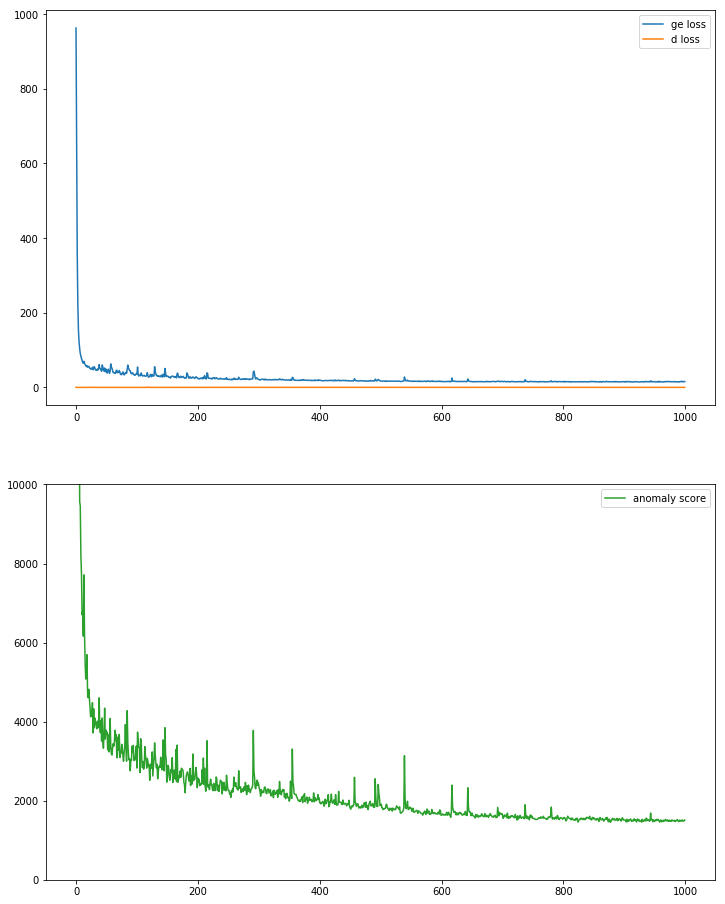

In [43]:
plt.figure(figsize=(12, 8*2))

plt.subplot(211)
plt.plot(range(len(loss_ge_list)), loss_ge_list, label="ge loss",color="C0")
plt.legend()

plt.plot(range(len(loss_d_list)), loss_d_list, label="d loss",color="C1")
plt.legend()
plt.subplot(212)
plt.plot(range(len(anomaly_score_list)), anomaly_score_list, label="anomaly score",color="C2")
plt.legend()
plt.ylim(0, 10000)

plt.show()

# Test Anomaly detection

In [44]:
LOAD_EPOCH = 1000


model_G = Generator().to(device)
model_G.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Generator_{LOAD_EPOCH}.pkl"))
model_G.eval()


model_E = Encoder().to(device)
model_E.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Encoder_{LOAD_EPOCH}.pkl"))
model_E.eval()

model_D = Discriminator().to(device)
model_D.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Discriminator_{LOAD_EPOCH}.pkl"))
model_D.eval()

print("load model")

load model


Anomaly_score: 198.620


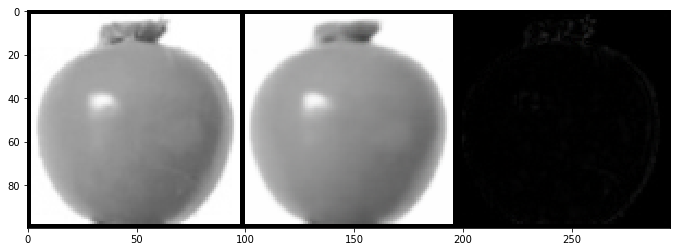

Anomaly_score: 190.558


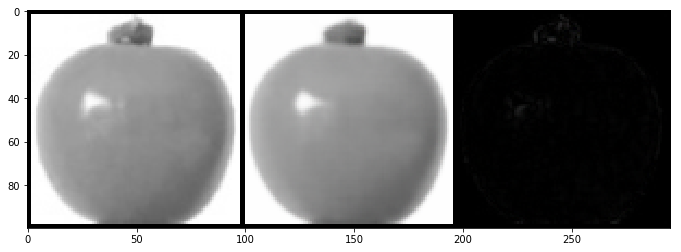

Anomaly_score: 256.910


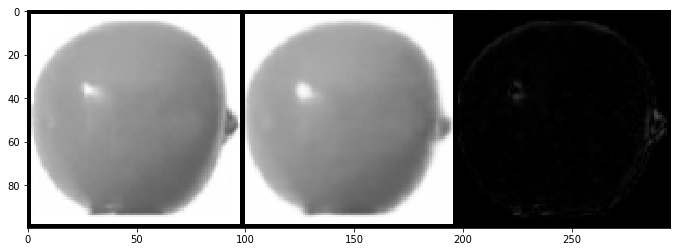

Anomaly_score: 202.401


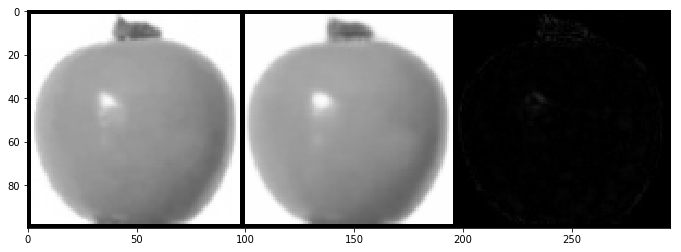

Anomaly_score: 485.565


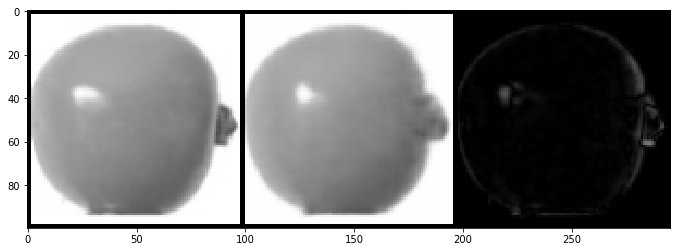

Anomaly_score: 519.398


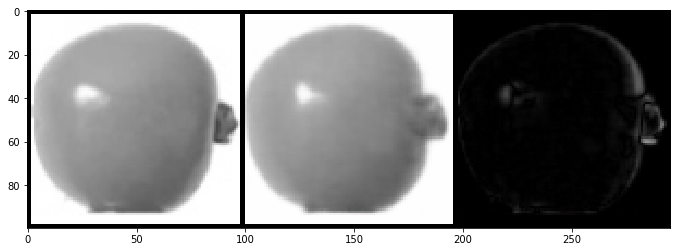

Anomaly_score: 533.423


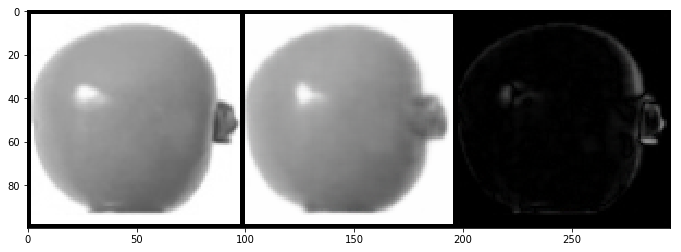

Anomaly_score: 204.931


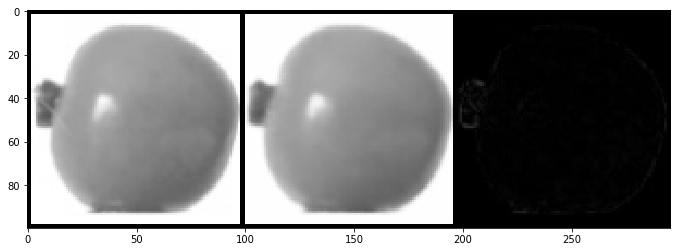

Anomaly_score: 167.886


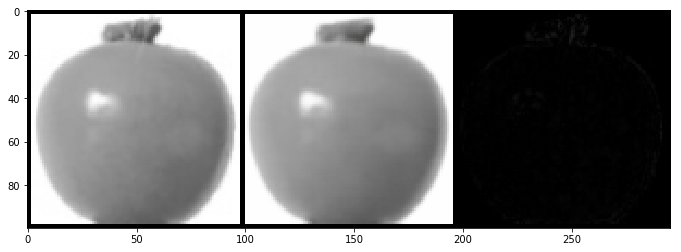

Anomaly_score: 221.841


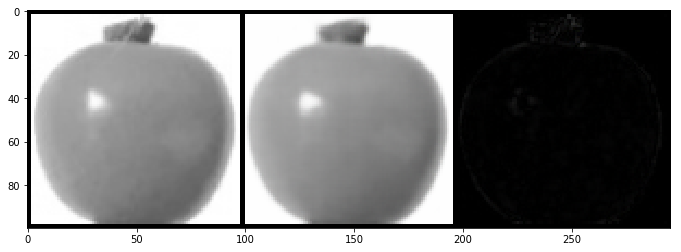

In [45]:
random_image_size = 10

test_root_normal = './data/fruits-360/Test/Physalis/'
test_dataset_normal = LoadFromFolder(test_root_normal, transform=transform_dict["test"])

test_images_normal = random.sample(list(test_dataset_normal), random_image_size)

for idx in range(len(test_images_normal)):

    x = test_images_normal[idx].view(1, 3, 96, 96).to(device)
    E_x = model_E(x)
    G_E_x = model_G(E_x)
    
    loss = Anomaly_score(x, E_x, G_E_x)
    diff_img = torch.abs(x - G_E_x)
    print(f"Anomaly_score: {loss:.3f}")
    comparison = torch.cat([x.to("cpu"), G_E_x.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow(joined_image)
    plt.show()

In [46]:
# 画像に傷を模した記号を付与する関数

def add_damage(image_path):
    
    folder = os.path.dirname(image_path)
    save_folder = folder + "_damaged"
    save_base_path = os.path.basename(image_path).replace(".jpg", "_damaged.jpg")
    save_path = os.path.join(save_folder, save_base_path)
    
    os.makedirs(save_folder, exist_ok=True)
    
    image = cv2.imread(image_path)
    center_x = random.randint(20, 76)
    center_y = random.randint(20, 76)
    color_r = random.randint(0, 255)
    color_g = random.randint(0, 255)
    color_b = random.randint(0, 255)
    
    center = (center_x, center_y)
    color = (color_r, color_g, color_b)
    
    cv2.circle(image, center = center, radius = 10, color = color,thickness=-1)
    cv2.imwrite(save_path, image)
    
images_path = glob('./data/fruits-360/Test/Physalis/*.jpg')
[add_damage(image_path) for image_path in images_path]
print("add damage")

add damage


Anomaly_score: 569.966


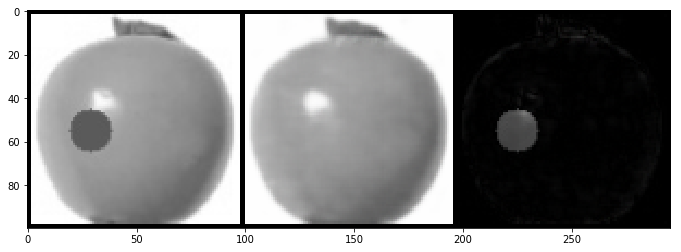

Anomaly_score: 606.501


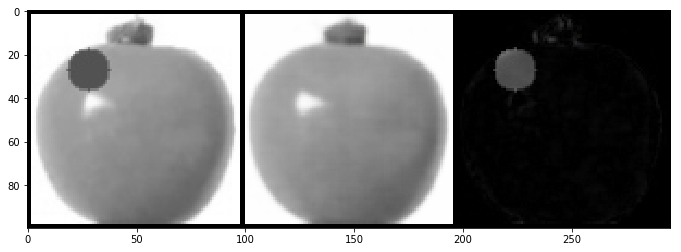

Anomaly_score: 707.057


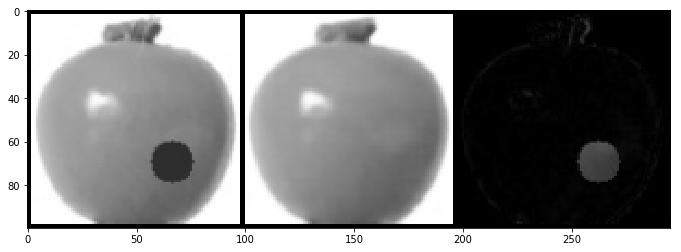

Anomaly_score: 314.486


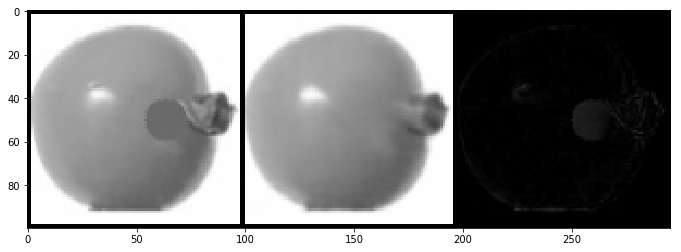

Anomaly_score: 1549.560


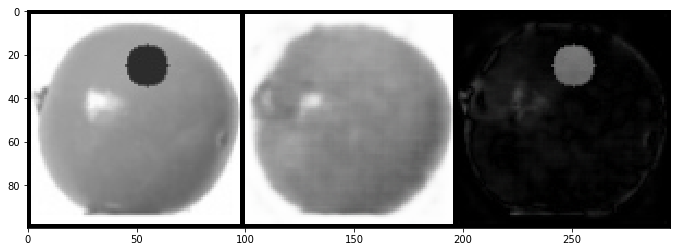

Anomaly_score: 222.457


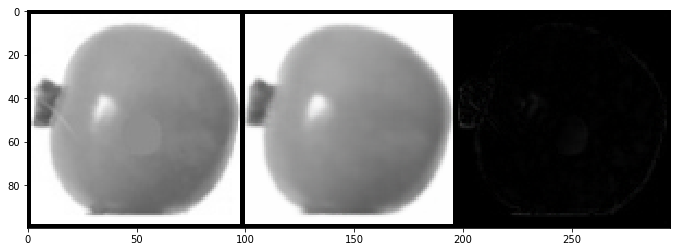

Anomaly_score: 586.647


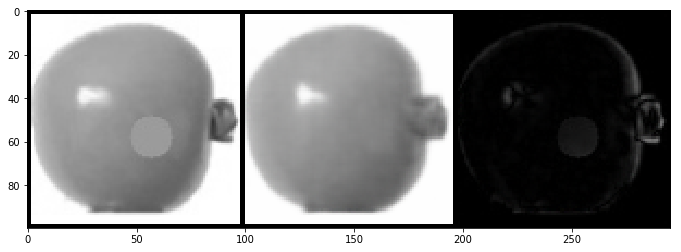

Anomaly_score: 963.314


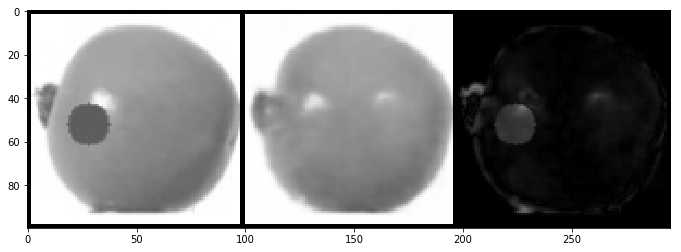

Anomaly_score: 418.580


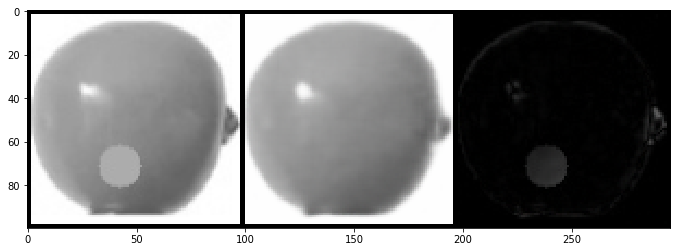

Anomaly_score: 224.589


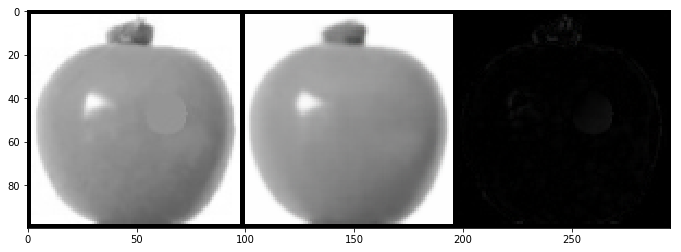

In [47]:
# 異常な画像で実行

test_root_anomaly = './data/fruits-360/Test/Physalis_damaged/'
test_dataset_anomaly = LoadFromFolder(test_root_anomaly, transform=transform_dict["test"])

test_images_anomaly = random.sample(list(test_dataset_anomaly), random_image_size)

# うまく再現されず、異常スコアが高くなっていれば成功
for idx in range(len(test_images_anomaly)):

    x = test_images_anomaly[idx].view(1, 3, 96, 96).to(device)
    E_x = model_E(x)
    G_E_x = model_G(E_x)
    
    loss = Anomaly_score(x, E_x, G_E_x)
    diff_img = torch.abs(x - G_E_x)
    print(f"Anomaly_score: {loss:.3f}")
    comparison = torch.cat([x.to("cpu"), G_E_x.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow(joined_image)
    plt.show()
